In [1]:
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [56]:
%run dataset_gc.ipynb

DATASET LOADED
Data(x=[42, 1], edge_index=[2, 40], edge_attr=[40, 1], y=[1])


Processing...
Done!


In [83]:
torch.manual_seed(42)
dataset = dataset_gc.shuffle()

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

print()
print('=============================================================')

print(data.x[0])
print(data.edge_attr.shape)
print(data.y)


Dataset: EnterpriseModelDataset(54):
Number of graphs: 54
Number of features: 1
Number of classes: 10

Data(x=[48, 1], edge_index=[2, 51], edge_attr=[51, 1], y=[1])
Number of nodes: 48
Number of edges: 51
Average node degree: 1.06
Has isolated nodes: False
Has self-loops: False
Is undirected: False

tensor([11.])
torch.Size([51, 1])
tensor([8])


In [84]:
torch.manual_seed(42)
dataset = dataset.shuffle()

train_dataset = dataset[:int(len(dataset) * 0.65)]
test_dataset = dataset[int(len(dataset) * 0.35):]

print(f'Number of graphs total: {len(dataset)}')
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of graphs total: 54
Number of training graphs: 35
Number of test graphs: 36


In [75]:
from torch_geometric.loader import DataLoader

NUM_GRAPHS_PER_BATCH = 6
NUM_HIDDEN_CHANNELS = 32

train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

#for step, data in enumerate(train_loader):
    #print(f'Step {step + 1}:')
    #print('=======')
    #print(f'Number of graphs in the current batch: {data.num_graphs}')
    #print(data)
    #print()

In [76]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, SAGEConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = SAGEConv(dataset.num_node_features, 2 * hidden_channels)
        self.conv2 = SAGEConv(2 * hidden_channels, 4 *  hidden_channels)
        self.conv3 = SAGEConv(4 * hidden_channels, 2 * hidden_channels)
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

#         x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x)
        x = self.lin2(x)
        
        return x


GCN(
  (conv1): SAGEConv(1, 64)
  (conv2): SAGEConv(64, 128)
  (conv3): SAGEConv(128, 64)
  (lin1): Linear(in_features=64, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=10, bias=True)
)
Number of parameters:  35562
Epoch: 001, Loss: 2.6992, Train Acc: 0.1143, Test Acc: 0.1111
Epoch: 002, Loss: 2.7856, Train Acc: 0.4571, Test Acc: 0.3333
Epoch: 003, Loss: 1.7511, Train Acc: 0.4571, Test Acc: 0.3333
Epoch: 004, Loss: 1.6107, Train Acc: 0.4857, Test Acc: 0.3611
Epoch: 005, Loss: 2.3084, Train Acc: 0.4571, Test Acc: 0.3333
Epoch: 006, Loss: 1.2182, Train Acc: 0.4857, Test Acc: 0.3611
Epoch: 007, Loss: 1.3010, Train Acc: 0.4857, Test Acc: 0.3611
Epoch: 008, Loss: 2.3873, Train Acc: 0.4571, Test Acc: 0.3333
Epoch: 009, Loss: 2.3667, Train Acc: 0.5429, Test Acc: 0.4444
Epoch: 010, Loss: 1.7154, Train Acc: 0.1429, Test Acc: 0.1389
Epoch: 011, Loss: 1.9828, Train Acc: 0.1143, Test Acc: 0.1389
Epoch: 012, Loss: 2.2546, Train Acc: 0.1429, Test Acc: 0.1389
Epoch: 013, L

Epoch: 131, Loss: 1.1483, Train Acc: 0.7714, Test Acc: 0.6667
Epoch: 132, Loss: 0.4454, Train Acc: 0.7714, Test Acc: 0.6944
Epoch: 133, Loss: 0.5357, Train Acc: 0.7714, Test Acc: 0.7222
Epoch: 134, Loss: 0.8674, Train Acc: 0.7714, Test Acc: 0.7222
Epoch: 135, Loss: 1.2321, Train Acc: 0.7714, Test Acc: 0.7500
Epoch: 136, Loss: 0.2795, Train Acc: 0.8286, Test Acc: 0.8333


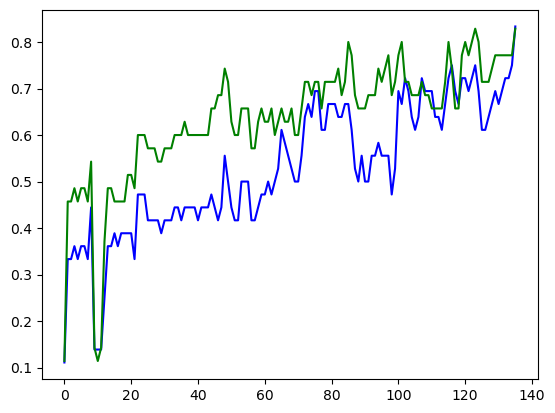

In [78]:
model = GCN(hidden_channels=NUM_HIDDEN_CHANNELS)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

loss_values = []
train_acc_values = []
acc_values = []

for epoch in range(1, 251):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
        
    loss_values.append(loss)
    acc_values.append(test_acc)
    train_acc_values.append(train_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    if(test_acc > 0.81):
        break

plt.plot( acc_values, 'b', train_acc_values, 'g')
plt.show()

### Fragen:

- "Generation of test enterprise models" <- was genau ist damit gemeint, bzw. was kann ich mir darunter vorstellen
        - "For testing purposes, several enterprise models were built with definitely correct and wrong elements."
        -> was kann ich mir darunter vorstellen?  gibt es die noch?
- wie relevant ist überhaupt die technische Umsetzung, also wie detailliert sollte ich meine Schritte beschreiben
- gibt es noch mehr Modelle, die ich benutzen könnte?
- Alle benutzten Layer, act.F. Algorithmen etc. im Vornherein erläutern oder währenddessen?
- Hyperparameteroptimierung sinnvoll oder nicht (weil nur POC oder so)
- Fragen link prediction
mermaid

In [79]:
torch.save(model, 'models/model_gc.pth')

In [80]:
loaded_model = torch.load('models/model_gc.pth')

In [81]:
loaded_model.eval()

GCN(
  (conv1): SAGEConv(1, 64)
  (conv2): SAGEConv(64, 128)
  (conv3): SAGEConv(128, 64)
  (lin1): Linear(in_features=64, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=10, bias=True)
)

In [85]:
def test_loaded(loader):
    loaded_model.eval()
    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = loaded_model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

test_acc = test_loaded(test_loader)
print(f'Test Acc: {test_acc:.4f}')

Test Acc: 0.8333
